# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 22.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=1cc7b8da7ccb633417be2924fdcaadf7b04602752b432ce58226f1676a7d84dc
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=c895a9020351fc359c1fb85a6d7f28c3e1104f897b19692c556f860399237cc2
  Stored in directory: /root/.cache/pip/w

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 20.39 MiB/s, done.
Resolving deltas: 100% (3/3), done.


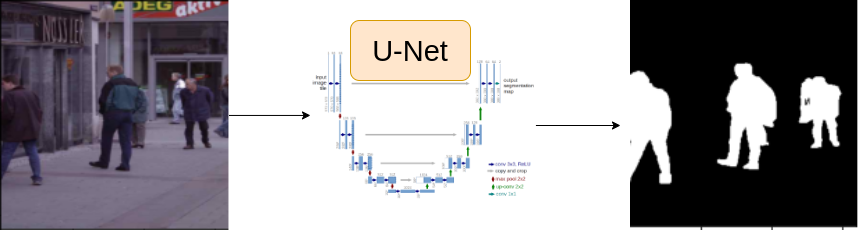

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [105]:
DATA_DIR = '/content/'
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DEVICE = 'CUDA'
EPOCHS = 100
LR = 0.0035
IMG_SIZE = 320
BATCH_SIZE = 32
ENCODER = 'timm-efficientnet-b1'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row_index = 57
row = df.iloc[row_index]
print(row.images)
image_path = row.images
mask_path = row.masks
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
resized_image = cv2.resize(image, (IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_AREA)
resized_mask = cv2.resize(mask, (IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_AREA)
print(f' mask dims are : {mask.shape}')
print(f' image dims are : {image.shape}')
print(f' resized mask dims are : {resized_mask.shape}')
print(f'resized image dims are : {resized_image.shape}')
import albumentations as A
transform = A.Compose([
    A.Resize(width=256, height=256)
])
transformed = transform(image=resized_image, mask=resized_mask)
transformed_image = transformed['image']
transformed_mask = transformed['mask']
print(f' transformed mask dims are : {transformed_mask.shape}')
print(f' transformed image dims are : {transformed_image.shape}')



Human-Segmentation-Dataset-master/Training_Images/150.jpg
 mask dims are : (577, 433)
 image dims are : (640, 480, 3)
 resized mask dims are : (320, 320)
resized image dims are : (320, 320, 3)
 transformed mask dims are : (256, 256)
 transformed image dims are : (256, 256, 3)


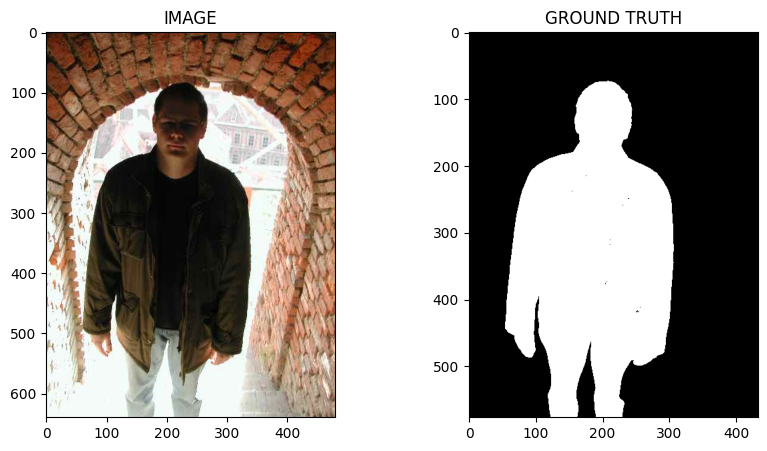

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask ,cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size= 0.2, random_state = 42)




# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A
get_train_augs_2 = A.Compose([
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5)])

def get_train_augs():
  return A.Compose([
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5)])
get_val_augs_2= A.Compose([
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5)])

def get_val_augs():
  return A.Compose([
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5)])  


# Task 4 : Create Custom Dataset 

In [11]:
from torch.utils.data import Dataset

In [81]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentations):
    self.df = df
    self.augmentations = augmentations
  def __len__(self):
    return len(self.df)
  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image_path = row.images
    mask_path = row.masks
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE,IMG_SIZE)) # Resizing it to 320x320
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_SIZE,IMG_SIZE)) # Resizing it to 320x320
    mask = np.expand_dims(mask, axis = -1)
    if self.augmentations :
      data = self.augmentations(image = image, mask=mask)
      image = data['image']
      mask = data['mask']
    image = np.transpose(image,(2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)
    image = torch.Tensor(image)/255
    mask = torch.round(torch.Tensor(mask)/255)
    return image, mask




In [82]:
trainset = SegmentationDataset(train_df,get_train_augs_2)
validset = SegmentationDataset(valid_df,get_val_augs_2)

In [83]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


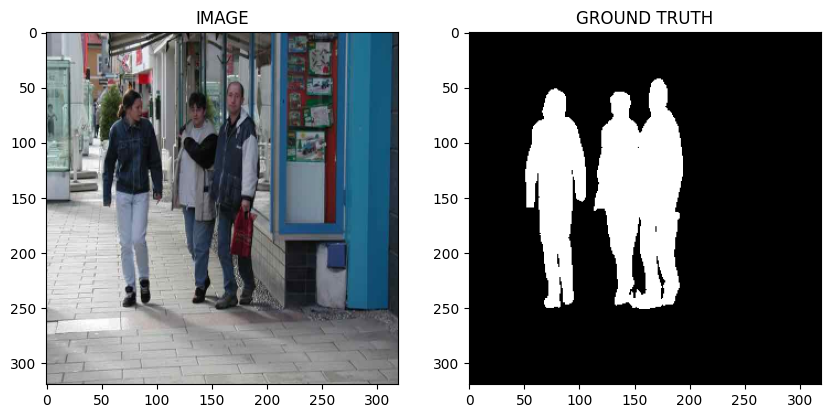

In [84]:
image, mask = trainset[42]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [85]:
from torch.utils.data import DataLoader

In [86]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [87]:
print(f"total number of batches in train loader : {len(trainloader)}" )
print(f"total number of batches in valid loader : {len(validloader)}" )

total number of batches in train loader : 15
total number of batches in valid loader : 4


In [88]:
for image, mask in trainloader :
  break
print(f'one batch IMAGE shape: {image.shape}')
print(f'one batch MASK shape: {mask.shape}')

one batch IMAGE shape: torch.Size([16, 3, 320, 320])
one batch MASK shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [41]:
from torch import nn
!pip install -U segmentation-models-pytorch
import segmentation_models_pytorch as smp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [99]:

from segmentation_models_pytorch.losses import DiceLoss
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()
    self.arc = smp.Unet(encoder_name = ENCODER,
                        encoder_weights = WEIGHTS,
                        in_channels = 3,
                        classes=1,
                        activation = None)
  def forward(self, images, masks = None):
    logits = self.arc(images)
    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits,masks)
      loss2 = nn.BCEWithLogitsLoss()(logits,masks)
      return logits, loss1 + loss2
    return logits
    
    


In [100]:
model = SegmentationModel()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b1_aa-ea7a6ee0.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b1_aa-ea7a6ee0.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 74.4MB/s]


# Task 7 : Create Train and Validation Function 

In [101]:
model.to('cuda');

In [106]:
def train_fn(data_loader, model , optimizer):
  model.train()
  total_loss = 0
  for images , masks in tqdm(data_loader):
    images = images.to('cuda')
    masks = masks.to('cuda')
    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    return total_loss / len(data_loader)


In [107]:
def valid_fn(data_loader, model , optimizer):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for images , masks in tqdm(data_loader):
      images = images.to('cuda')
      masks = masks.to('cuda')
      logits, loss = model(images, masks)
      total_loss += loss.item()
  return total_loss / len(data_loader)

# Task 8 : Train Model

In [116]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
#optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum = 0.9)

In [117]:
best_valid_loss = np.inf
for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = valid_fn(validloader, model, optimizer)
  if (valid_loss < best_valid_loss) :
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED MODEL")
  print(f"EPOCH : {i+1} / {range(EPOCHS)} TRAIN LOSS : {train_loss} VALID LOSS : {valid_loss}")



100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


SAVED MODEL
EPOCH : 1 TRAIN LOSS : 0.06362815300623575 VALID LOSS 9.680647134780884


100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


SAVED MODEL
EPOCH : 2 TRAIN LOSS : 0.06695391337076823 VALID LOSS 19.38140606880188


100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


SAVED MODEL
EPOCH : 3 TRAIN LOSS : 0.05923951466878255 VALID LOSS 44.256521701812744


100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


SAVED MODEL
EPOCH : 4 TRAIN LOSS : 0.043928134441375735 VALID LOSS 22.609690189361572


100%|██████████| 4/4 [00:00<00:00,  4.54it/s]


SAVED MODEL
EPOCH : 5 TRAIN LOSS : 0.029923288027445476 VALID LOSS 8.571592569351196


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


SAVED MODEL
EPOCH : 6 TRAIN LOSS : 0.031017941236495972 VALID LOSS 12.728275179862976


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


SAVED MODEL
EPOCH : 7 TRAIN LOSS : 0.03220384518305461 VALID LOSS 10.982668042182922


100%|██████████| 4/4 [00:01<00:00,  3.63it/s]


SAVED MODEL
EPOCH : 8 TRAIN LOSS : 0.03220526377360026 VALID LOSS 3.1693909764289856


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


SAVED MODEL
EPOCH : 9 TRAIN LOSS : 0.024893546104431154 VALID LOSS 2.8512932658195496


100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


SAVED MODEL
EPOCH : 10 TRAIN LOSS : 0.024802851676940917 VALID LOSS 2.8739174008369446


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


SAVED MODEL
EPOCH : 11 TRAIN LOSS : 0.022503358125686646 VALID LOSS 2.764654129743576


100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


SAVED MODEL
EPOCH : 12 TRAIN LOSS : 0.03201935489972432 VALID LOSS 2.46479269862175


100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


SAVED MODEL
EPOCH : 13 TRAIN LOSS : 0.02391389807065328 VALID LOSS 2.1296666860580444


100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


SAVED MODEL
EPOCH : 14 TRAIN LOSS : 0.025846771399180093 VALID LOSS 2.2354764342308044


100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


SAVED MODEL
EPOCH : 15 TRAIN LOSS : 0.0387330691019694 VALID LOSS 1.3043415695428848


100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


SAVED MODEL
EPOCH : 16 TRAIN LOSS : 0.026660255591074624 VALID LOSS 0.9688186645507812


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


SAVED MODEL
EPOCH : 17 TRAIN LOSS : 0.02820582389831543 VALID LOSS 1.0202529430389404


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


SAVED MODEL
EPOCH : 18 TRAIN LOSS : 0.0218032975991567 VALID LOSS 1.131877213716507


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


SAVED MODEL
EPOCH : 19 TRAIN LOSS : 0.022643474737803142 VALID LOSS 0.9437974840402603


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


SAVED MODEL
EPOCH : 20 TRAIN LOSS : 0.020200574398040773 VALID LOSS 0.9235525578260422


100%|██████████| 4/4 [00:01<00:00,  2.04it/s]


SAVED MODEL
EPOCH : 21 TRAIN LOSS : 0.03649903535842895 VALID LOSS 1.1493527740240097


100%|██████████| 4/4 [00:01<00:00,  3.20it/s]


SAVED MODEL
EPOCH : 22 TRAIN LOSS : 0.021791307131449382 VALID LOSS 1.0430336892604828


100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


SAVED MODEL
EPOCH : 23 TRAIN LOSS : 0.021242970228195192 VALID LOSS 1.141384318470955


100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


SAVED MODEL
EPOCH : 24 TRAIN LOSS : 0.026646316051483154 VALID LOSS 1.107460081577301


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


SAVED MODEL
EPOCH : 25 TRAIN LOSS : 0.022049715121587116 VALID LOSS 0.7995885461568832


100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


SAVED MODEL
EPOCH : 26 TRAIN LOSS : 0.023720939954121906 VALID LOSS 0.5848573669791222


100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


SAVED MODEL
EPOCH : 27 TRAIN LOSS : 0.027114466826121012 VALID LOSS 0.47911833971738815


100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


SAVED MODEL
EPOCH : 28 TRAIN LOSS : 0.028277931610743205 VALID LOSS 0.5717101022601128


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


SAVED MODEL
EPOCH : 29 TRAIN LOSS : 0.020403778553009032 VALID LOSS 0.8761628866195679


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


SAVED MODEL
EPOCH : 30 TRAIN LOSS : 0.017868908246358235 VALID LOSS 0.9381464868783951


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


SAVED MODEL
EPOCH : 31 TRAIN LOSS : 0.017606091499328614 VALID LOSS 0.7214653342962265


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


SAVED MODEL
EPOCH : 32 TRAIN LOSS : 0.014465248584747315 VALID LOSS 0.5968253463506699


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


SAVED MODEL
EPOCH : 33 TRAIN LOSS : 0.01765369772911072 VALID LOSS 0.421511672437191


100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


SAVED MODEL
EPOCH : 34 TRAIN LOSS : 0.01563565731048584 VALID LOSS 0.370498962700367


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


SAVED MODEL
EPOCH : 35 TRAIN LOSS : 0.01523248553276062 VALID LOSS 0.33884167671203613


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


SAVED MODEL
EPOCH : 36 TRAIN LOSS : 0.019176220893859862 VALID LOSS 0.3516654744744301


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


SAVED MODEL
EPOCH : 37 TRAIN LOSS : 0.026246386766433715 VALID LOSS 0.42045721411705017


100%|██████████| 4/4 [00:01<00:00,  3.82it/s]


SAVED MODEL
EPOCH : 38 TRAIN LOSS : 0.024800129731496177 VALID LOSS 0.4175104945898056


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]


SAVED MODEL
EPOCH : 39 TRAIN LOSS : 0.037109994888305665 VALID LOSS 0.37666740640997887


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


SAVED MODEL
EPOCH : 40 TRAIN LOSS : 0.017418883244196572 VALID LOSS 0.43447883427143097


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


SAVED MODEL
EPOCH : 41 TRAIN LOSS : 0.01520070234934489 VALID LOSS 0.3743254020810127


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


SAVED MODEL
EPOCH : 42 TRAIN LOSS : 0.023234808444976808 VALID LOSS 0.3540077209472656


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


SAVED MODEL
EPOCH : 43 TRAIN LOSS : 0.020364777247111002 VALID LOSS 0.3277040645480156


100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


SAVED MODEL
EPOCH : 44 TRAIN LOSS : 0.02034535606702169 VALID LOSS 0.33630044013261795


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


SAVED MODEL
EPOCH : 45 TRAIN LOSS : 0.015072309970855713 VALID LOSS 0.4273829758167267


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


SAVED MODEL
EPOCH : 46 TRAIN LOSS : 0.024374783039093018 VALID LOSS 0.4197201058268547


100%|██████████| 4/4 [00:01<00:00,  3.87it/s]


SAVED MODEL
EPOCH : 47 TRAIN LOSS : 0.014540114005406697 VALID LOSS 0.41393766179680824


100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


SAVED MODEL
EPOCH : 48 TRAIN LOSS : 0.013437110185623168 VALID LOSS 0.3918835446238518


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


SAVED MODEL
EPOCH : 49 TRAIN LOSS : 0.019362648328145344 VALID LOSS 0.31193534284830093


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


SAVED MODEL
EPOCH : 50 TRAIN LOSS : 0.016464006900787354 VALID LOSS 0.3318679481744766


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


SAVED MODEL
EPOCH : 51 TRAIN LOSS : 0.01387474238872528 VALID LOSS 0.2769414111971855


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


SAVED MODEL
EPOCH : 52 TRAIN LOSS : 0.015148780743281047 VALID LOSS 0.2535404935479164


100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


SAVED MODEL
EPOCH : 53 TRAIN LOSS : 0.013912882407506306 VALID LOSS 0.2445085123181343


100%|██████████| 4/4 [00:01<00:00,  3.66it/s]


SAVED MODEL
EPOCH : 54 TRAIN LOSS : 0.018911582231521607 VALID LOSS 0.2491956353187561


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


SAVED MODEL
EPOCH : 55 TRAIN LOSS : 0.012331899007161458 VALID LOSS 0.25084662437438965


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


SAVED MODEL
EPOCH : 56 TRAIN LOSS : 0.018080127239227296 VALID LOSS 0.21945570409297943


100%|██████████| 4/4 [00:00<00:00,  4.62it/s]


SAVED MODEL
EPOCH : 57 TRAIN LOSS : 0.03279727896054586 VALID LOSS 0.2862941212952137


100%|██████████| 4/4 [00:00<00:00,  4.59it/s]


SAVED MODEL
EPOCH : 58 TRAIN LOSS : 0.01455749273300171 VALID LOSS 0.26144931092858315


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


SAVED MODEL
EPOCH : 59 TRAIN LOSS : 0.013405030965805054 VALID LOSS 0.32426461577415466


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


SAVED MODEL
EPOCH : 60 TRAIN LOSS : 0.01619118352731069 VALID LOSS 0.28644131124019623


100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


SAVED MODEL
EPOCH : 61 TRAIN LOSS : 0.01189282735188802 VALID LOSS 0.3068009242415428


100%|██████████| 4/4 [00:01<00:00,  3.60it/s]


SAVED MODEL
EPOCH : 62 TRAIN LOSS : 0.022646443049112955 VALID LOSS 0.2935904338955879


100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


SAVED MODEL
EPOCH : 63 TRAIN LOSS : 0.01601716677347819 VALID LOSS 0.28074340894818306


100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


SAVED MODEL
EPOCH : 64 TRAIN LOSS : 0.013943419853846232 VALID LOSS 0.2947368174791336


100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


SAVED MODEL
EPOCH : 65 TRAIN LOSS : 0.012520148356755575 VALID LOSS 0.2986105754971504


100%|██████████| 4/4 [00:00<00:00,  4.58it/s]


SAVED MODEL
EPOCH : 66 TRAIN LOSS : 0.018026832739512125 VALID LOSS 0.29928436130285263


100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


SAVED MODEL
EPOCH : 67 TRAIN LOSS : 0.022428433100382488 VALID LOSS 0.2950279414653778


100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


SAVED MODEL
EPOCH : 68 TRAIN LOSS : 0.015187032024065654 VALID LOSS 0.26714150607585907


100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


SAVED MODEL
EPOCH : 69 TRAIN LOSS : 0.01451147198677063 VALID LOSS 0.24904418364167213


100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


SAVED MODEL
EPOCH : 70 TRAIN LOSS : 0.020125508308410645 VALID LOSS 0.24176913127303123


100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


SAVED MODEL
EPOCH : 71 TRAIN LOSS : 0.01577529509862264 VALID LOSS 0.2568911947309971


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


SAVED MODEL
EPOCH : 72 TRAIN LOSS : 0.01863675912221273 VALID LOSS 0.3049371615052223


100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


SAVED MODEL
EPOCH : 73 TRAIN LOSS : 0.014886046449343363 VALID LOSS 0.2920815423130989


100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


SAVED MODEL
EPOCH : 74 TRAIN LOSS : 0.02245209217071533 VALID LOSS 0.32146118208765984


100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


SAVED MODEL
EPOCH : 75 TRAIN LOSS : 0.011785093943277996 VALID LOSS 0.286847822368145


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


SAVED MODEL
EPOCH : 76 TRAIN LOSS : 0.02014609972635905 VALID LOSS 0.2845345512032509


100%|██████████| 4/4 [00:00<00:00,  4.59it/s]


SAVED MODEL
EPOCH : 77 TRAIN LOSS : 0.02239157756169637 VALID LOSS 0.25426264107227325


100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


SAVED MODEL
EPOCH : 78 TRAIN LOSS : 0.014413212736447653 VALID LOSS 0.26007355004549026


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


SAVED MODEL
EPOCH : 79 TRAIN LOSS : 0.01382315754890442 VALID LOSS 0.28282298520207405


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


SAVED MODEL
EPOCH : 80 TRAIN LOSS : 0.02132919430732727 VALID LOSS 0.2400190494954586


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


SAVED MODEL
EPOCH : 81 TRAIN LOSS : 0.012898095448811849 VALID LOSS 0.22988960519433022


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


SAVED MODEL
EPOCH : 82 TRAIN LOSS : 0.02075959841410319 VALID LOSS 0.212761539965868


100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


SAVED MODEL
EPOCH : 83 TRAIN LOSS : 0.012642375628153483 VALID LOSS 0.2171175703406334


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


SAVED MODEL
EPOCH : 84 TRAIN LOSS : 0.014761787652969361 VALID LOSS 0.20895664021372795


100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


SAVED MODEL
EPOCH : 85 TRAIN LOSS : 0.011539389689763388 VALID LOSS 0.25435465574264526


100%|██████████| 4/4 [00:01<00:00,  2.95it/s]


SAVED MODEL
EPOCH : 86 TRAIN LOSS : 0.010875157515207927 VALID LOSS 0.2602652944624424


100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


SAVED MODEL
EPOCH : 87 TRAIN LOSS : 0.013153652350107828 VALID LOSS 0.2687935642898083


100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


SAVED MODEL
EPOCH : 88 TRAIN LOSS : 0.02375863790512085 VALID LOSS 0.23432151228189468


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


SAVED MODEL
EPOCH : 89 TRAIN LOSS : 0.016401182611783346 VALID LOSS 0.21958637237548828


100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


SAVED MODEL
EPOCH : 90 TRAIN LOSS : 0.01168980598449707 VALID LOSS 0.2455902360379696


100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


SAVED MODEL
EPOCH : 91 TRAIN LOSS : 0.013314473628997802 VALID LOSS 0.22929377481341362


100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


SAVED MODEL
EPOCH : 92 TRAIN LOSS : 0.012132408221562703 VALID LOSS 0.22354719787836075


100%|██████████| 4/4 [00:02<00:00,  1.34it/s]


SAVED MODEL
EPOCH : 93 TRAIN LOSS : 0.015290723244349162 VALID LOSS 0.22185422480106354


100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


SAVED MODEL
EPOCH : 94 TRAIN LOSS : 0.017273688316345216 VALID LOSS 0.23827635869383812


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


SAVED MODEL
EPOCH : 95 TRAIN LOSS : 0.01686791777610779 VALID LOSS 0.22683213651180267


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


SAVED MODEL
EPOCH : 96 TRAIN LOSS : 0.008033129076162973 VALID LOSS 0.21258794888854027


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


SAVED MODEL
EPOCH : 97 TRAIN LOSS : 0.015019991000493367 VALID LOSS 0.23188203945755959


100%|██████████| 4/4 [00:00<00:00,  4.52it/s]


SAVED MODEL
EPOCH : 98 TRAIN LOSS : 0.010601842403411865 VALID LOSS 0.23053206130862236


100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


SAVED MODEL
EPOCH : 99 TRAIN LOSS : 0.02040533224741618 VALID LOSS 0.24966943636536598


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]

SAVED MODEL
EPOCH : 100 TRAIN LOSS : 0.011717267831166585 VALID LOSS 0.2593651972711086


# Task 9 : Inference

In [132]:
idx = 55
model.load_state_dict(torch.load('/content/best_model.pt'))
model.eval()
image, mask = trainset[idx]
logits_mask = model(image.to('cuda').unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0





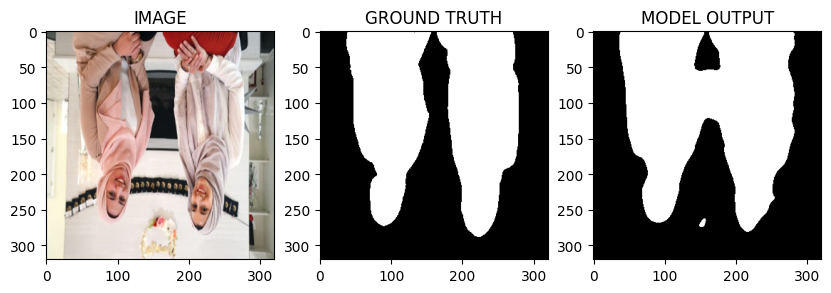

In [133]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya